In [105]:
import warnings
warnings.filterwarnings("ignore")

In [106]:
import pandas as pd
import numpy as np
datos = pd.read_excel("02.Generación Pearson Photovoltaic.xlsx")
datos["Generacion_prev_hour"] = datos["Generación"].shift(1)
datos = datos.dropna(how="any", axis= 0)
datos.index = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%s')
datos['Segundos'] = datos.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day

datos['Day sin'] = np.sin(datos['Segundos'] * (2* np.pi /day))
datos['Day cos'] = np.cos(datos['Segundos'] * (2* np.pi /day))
datos['Year sin'] = np.sin(datos['Segundos'] * (2* np.pi /year))
datos['Year cos'] = np.cos(datos['Segundos'] * (2* np.pi /year))
datos['Gen_MA3'] = datos['Generación'].rolling(window=3).mean()
datos['Gen_MA6'] = datos['Generación'].rolling(window=6).mean()
datos['Gen_MA12'] = datos['Generación'].rolling(window=12).mean()
datos['Gen_Diff3'] = datos['Generación'].diff(3)
datos['Temp * UV'] = datos['Temperatura'] * datos['Índice UV']
datos['Humedad / Temp'] = datos['Humedad Relativa'] / (datos['Temperatura'] + 1)

datos = datos.drop(columns=['Fecha', 'Segundos'], axis=1)
datos = datos[(datos['Hora']>=6) & (datos['Hora']<=19)]
datos.head(4)

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour,Day sin,Day cos,Year sin,Year cos,Gen_MA3,Gen_MA6,Gen_MA12,Gen_Diff3,Temp * UV,Humedad / Temp
Fecha,,,,,,,,,,,,,,,,,,,
2022-09-01 06:00:00,0.000000,0.0,18,6,16,54,3,89,0.000000,1.000000,-1.432608e-13,-0.867270,-0.497838,0.000000,0.000000,NaN,0.000000,0.0,4.684211
2022-09-01 07:00:00,6.584959,0.0,18,7,17,70,4,95,0.000000,0.965926,-2.588190e-01,-0.867627,-0.497216,2.194986,1.097493,NaN,6.584959,0.0,5.000000
2022-09-01 08:00:00,560.422022,0.0,18,8,18,72,3,100,6.584959,0.866025,-5.000000e-01,-0.867983,-0.496594,189.002327,94.501163,NaN,560.422022,0.0,5.263158
2022-09-01 09:00:00,7720.582326,1.0,18,9,18,81,4,100,560.422022,0.707107,-7.071068e-01,-0.868338,-0.495972,2762.529769,1381.264885,NaN,7720.582326,18.0,5.263158


División de datos en Soleado, nublado y lluvioso

In [107]:
datosX = datos[['Índice UV', 'Temperatura', 'Hora', 'DPT',
       'Cobertura Nubes', 'Condición Cielo', 'Humedad Relativa']]

In [108]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(datosX)

In [109]:
from sklearn.mixture import GaussianMixture
# Definir el número de clusters (puedes ajustar el valor de n_components)
n_clusters = 3  # Puedes probar con otros valores
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
clusters = gmm.fit_predict(X_scaled)

In [110]:
datos['Cluster'] = clusters
datos

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour,Day sin,Day cos,Year sin,Year cos,Gen_MA3,Gen_MA6,Gen_MA12,Gen_Diff3,Temp * UV,Humedad / Temp,Cluster
Fecha,,,,,,,,,,,,,,,,,,,,
2022-09-01 06:00:00,0.000000,0.0,18,6,16,54,3,89,0.000000,1.000000,-1.432608e-13,-0.867270,-0.497838,0.000000,0.000000,NaN,0.000000,0.0,4.684211,1
2022-09-01 07:00:00,6.584959,0.0,18,7,17,70,4,95,0.000000,0.965926,-2.588190e-01,-0.867627,-0.497216,2.194986,1.097493,NaN,6.584959,0.0,5.000000,1
2022-09-01 08:00:00,560.422022,0.0,18,8,18,72,3,100,6.584959,0.866025,-5.000000e-01,-0.867983,-0.496594,189.002327,94.501163,NaN,560.422022,0.0,5.263158,1
2022-09-01 09:00:00,7720.582326,1.0,18,9,18,81,4,100,560.422022,0.707107,-7.071068e-01,-0.868338,-0.495972,2762.529769,1381.264885,NaN,7720.582326,18.0,5.263158,1
2022-09-01 10:00:00,9433.109309,2.0,19,10,18,89,4,93,7720.582326,0.500000,-8.660254e-01,-0.868694,-0.495350,5904.704552,2953.449769,NaN,9426.524350,38.0,4.650000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02 15:00:00,25562.000000,5.0,25,15,8,43,3,34,25399.000000,-0.707107,-7.071068e-01,-0.999622,0.027489,25519.666667,25416.333333,14796.583333,-715.000000,125.0,1.307692,2
2024-10-02 16:00:00,25386.000000,4.0,26,16,8,25,2,31,25562.000000,-0.866025,-5.000000e-01,-0.999602,0.028205,25449.000000,25757.500000,16912.083333,-212.000000,104.0,1.148148,0
2024-10-02 17:00:00,22872.000000,2.0,26,17,8,18,1,32,25386.000000,-0.965926,-2.588190e-01,-0.999582,0.028922,24606.666667,25182.333333,18818.083333,-2527.000000,52.0,1.185185,0


In [111]:
print(datos['Cluster'].value_counts())
# Calcular estadísticas de cada cluster
cluster_means = datos.groupby('Cluster').mean()
cluster_means

Cluster
1    4094
0    3691
2    2855
Name: count, dtype: int64


,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour,Day sin,Day cos,Year sin,Year cos,Gen_MA3,Gen_MA6,Gen_MA12,Gen_Diff3,Temp * UV,Humedad / Temp
Cluster,,,,,,,,,,,,,,,,,,,
0,21024.790228,5.603630,25.351395,14.727445,7.565429,14.290436,1.244378,32.178271,22551.184395,-0.507539,-0.560556,0.034295,-0.086844,22047.320432,20208.093241,13280.402088,13.452406,147.909428,1.563176
1,9963.842174,1.491744,14.613581,8.456277,11.130191,59.535173,3.051539,80.786273,6245.437474,0.716168,-0.528337,-0.135894,0.036651,6419.196063,3437.647115,1803.846752,8919.734216,25.467269,5.892611
2,18540.441229,3.251839,24.339054,15.418914,8.618214,80.148511,3.612960,38.652539,20595.268850,-0.627940,-0.470769,0.008259,0.021281,20074.254912,19239.314009,13298.231843,-1692.130973,81.718739,1.742451


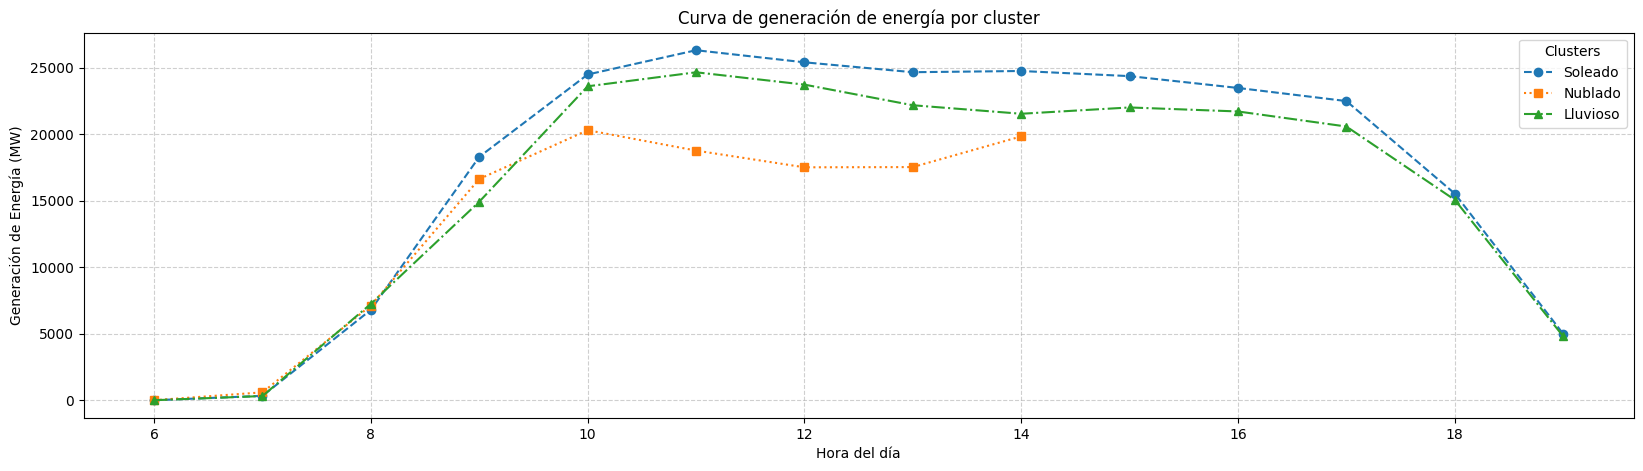

In [112]:
import matplotlib.pyplot as plt
df_grouped = datos.groupby(['Hora', 'Cluster'])['Generación'].mean().reset_index()

plt.figure(figsize=(20,5))

clusters = df_grouped['Cluster'].unique()

# Definir estilos para cada cluster
line_styles = ['dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1)), (0, (5, 1))]
markers = ['o', 's', '^', 'D', 'x']

# Dibujar una línea para cada cluster
for i, cluster in enumerate(clusters):
    if cluster == 0:
        label = 'Soleado'
    if cluster == 1:
        label = 'Nublado'
    if cluster == 2:
        label = 'Lluvioso'
    subset = df_grouped[df_grouped['Cluster'] == cluster]
    plt.plot(subset['Hora'], subset['Generación'], 
             linestyle=line_styles[i % len(line_styles)], 
             marker=markers[i % len(markers)], 
             label=label)

# Configuración de la gráfica
plt.xlabel("Hora del día")
plt.ylabel("Generación de Energía (MW)")
plt.title("Curva de generación de energía por cluster")
plt.legend(title="Clusters")
plt.grid(True, linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()

Cluster 0: Soleado, Cluster 1: Nublado, Cluster 2: Lluvioso

Entrenamiento 70-30

In [113]:
import numpy as np
def datos_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [114]:
WINDOW_SIZE = 20
X_Soleado, y_Soleado = datos_to_X_y(datos[datos['Cluster']==0].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Nublado, y_Nublado = datos_to_X_y(datos[datos['Cluster']==1].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Lluvioso, y_Lluvioso = datos_to_X_y(datos[datos['Cluster']==2].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Soleado.shape, y_Soleado.shape, X_Nublado.shape, y_Nublado.shape, X_Lluvioso.shape, y_Lluvioso.shape

((3671, 20, 19), (3671,), (4074, 20, 19), (4074,), (2835, 20, 19), (2835,))

In [115]:
num_datos_Soleado = X_Soleado.shape[0]
train_Soleado = int(round(num_datos_Soleado * 0.7,0))
val_Soleado = int(train_Soleado + round((num_datos_Soleado - train_Soleado) / 2, 0))

num_datos_Nublado = X_Nublado.shape[0]
train_Nublado = int(round(num_datos_Nublado * 0.7,0))
val_Nublado = int(train_Nublado + round((num_datos_Nublado - train_Nublado) / 2, 0))

num_datos_Lluvioso = X_Lluvioso.shape[0]
train_Lluvioso = int(round(num_datos_Lluvioso * 0.7,0))
val_Lluvioso = int(train_Lluvioso + round((num_datos_Lluvioso - train_Lluvioso) / 2, 0))

num_datos_Soleado, train_Soleado, val_Soleado, num_datos_Nublado, train_Nublado, val_Nublado, num_datos_Lluvioso, train_Lluvioso, val_Lluvioso

(3671, 2570, 3120, 4074, 2852, 3463, 2835, 1984, 2410)

In [116]:
X_Soleado_train, y_Soleado_train = X_Soleado[:train_Soleado], y_Soleado[:train_Soleado]
X_Soleado_test, y_Soleado_test = X_Soleado[train_Soleado:], y_Soleado[train_Soleado:]
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_test.shape, y_Soleado_test.shape

((2570, 20, 19), (2570,), (1101, 20, 19), (1101,))

In [117]:
X_Nublado_train, y_Nublado_train = X_Nublado[:train_Nublado], y_Nublado[:train_Nublado]
X_Nublado_test, y_Nublado_test = X_Nublado[train_Nublado:], y_Nublado[train_Nublado:]
X_Nublado_train.shape, y_Nublado_train.shape, X_Nublado_test.shape, y_Nublado_test.shape

((2852, 20, 19), (2852,), (1222, 20, 19), (1222,))

In [118]:
X_Lluvioso_train, y_Lluvioso_train = X_Lluvioso[:train_Lluvioso], y_Lluvioso[:train_Lluvioso]
X_Lluvioso_test, y_Lluvioso_test = X_Lluvioso[train_Lluvioso:], y_Lluvioso[train_Lluvioso:]
X_Lluvioso_train.shape, y_Lluvioso_train.shape, X_Lluvioso_test.shape, y_Lluvioso_test.shape

((1984, 20, 19), (1984,), (851, 20, 19), (851,))

Definición del modelo

In [119]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [120]:
inputs = Input(shape=(WINDOW_SIZE, X_Soleado_train.shape[2]))

# Primera capa CNN
x = Conv1D(filters=64, kernel_size=4, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)

# Segunda capa CNN
x = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Capa BiGRU
x = Bidirectional(GRU(64, return_sequences=True))(x)

# Atención: se define de forma explícita
attention = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)

# Aplanar y agregar Dropout
x = Flatten()(attention)
x = Dropout(0.4)(x)
initializer = tf.keras.initializers.HeNormal()
x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dense(32, activation="relu")(x)  # Otra capa intermedia

# Capa de salida
outputs = Dense(1, activation="linear")(x)

# Definir el modelo
model_Soleado = Model(inputs=inputs, outputs=outputs)

# Resumen del modelo
model_Soleado.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 20, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 20, 64)    │      4,928 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 10, 64)    │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 128)   │     32,896 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 5, 128)    │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 5, 128)    │     74,496 │ max_pooling1d_11… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │    263,808 │ bidirectional_6[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 640)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 640)       │          0 │ flatten_5[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     41,024 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 419,265 (1.60 MB)

 Trainable params: 419,265 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
cp = ModelCheckpoint('Photovoltaic_model_Soleado.keras', save_best_only=True)
model_Soleado.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error", metrics=['mae'])

In [122]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [123]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

In [124]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_Soleado_train = scaler_X.fit_transform(X_Soleado_train.reshape(-1, X_Soleado_train.shape[-1])).reshape(X_Soleado_train.shape)
X_Soleado_test = scaler_X.transform(X_Soleado_test.reshape(-1, X_Soleado_test.shape[-1])).reshape(X_Soleado_test.shape)

y_Soleado_train = scaler_y.fit_transform(y_Soleado_train.reshape(-1, 1)).reshape(-1)
y_Soleado_test = scaler_y.transform(y_Soleado_test.reshape(-1, 1)).reshape(-1)


In [125]:
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_test.shape, y_Soleado_test.shape

((2570, 20, 19), (2570,), (1101, 20, 19), (1101,))

In [126]:
history = model_Soleado.fit(
    X_Soleado_train, y_Soleado_train,
    validation_data=(X_Soleado_test, y_Soleado_test),
    epochs=50,
    batch_size=16,
    callbacks=[cp, early_stop]
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 1.2113 - mae: 0.3009 - val_loss: 0.8398 - val_mae: 0.1628
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7688 - mae: 0.2001 - val_loss: 0.5517 - val_mae: 0.1633
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5135 - mae: 0.1854 - val_loss: 0.3729 - val_mae: 0.1750
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3502 - mae: 0.1842 - val_loss: 0.2544 - val_mae: 0.1628
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2400 - mae: 0.1706 - val_loss: 0.1832 - val_mae: 0.1519
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1723 - mae: 0.1683 - val_loss: 0.1308 - val_mae: 0.1369
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1250 - mae: 0.1573 - val_loss: 0.0999 - val_mae: 0.1384
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0964 - mae: 0.1512 - val_loss: 0.0846 - val_mae: 0.1507
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/

In [127]:
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score
def plot_predictions1(model, X, y, scaler_y, history, start=0, end=100):
    predictions = model.predict(X).flatten()
    y = y.flatten()
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
    predictions_original = np.clip(predictions_original, 0, 30000)
    y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(-1)
    df = pd.DataFrame(data={'Predictions': predictions_original, 'Actuals': y_original})
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crear la gráfica
    print(f"MAE: {mean_absolute_error(y_original, predictions_original):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_original, predictions_original)):.4f}")
    print(f"R²: {r2_score(y_original, predictions_original):.4f}")
    plt.plot(train_loss, label='Pérdida Entrenamiento')
    plt.plot(val_loss, label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(y_original, label='Valor Real', color='blue')
    plt.plot(predictions_original, label='Predicción', color='red', linestyle='dashed')
    plt.xlabel("Hora")
    plt.ylabel("Valor")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
MAE: 3146.7442
RMSE: 4819.0145
R²: 0.5592


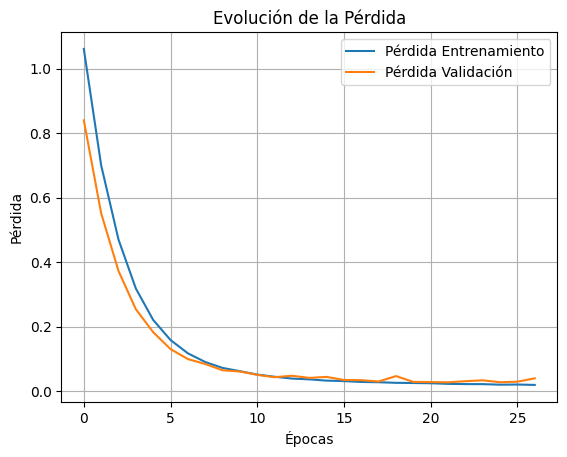

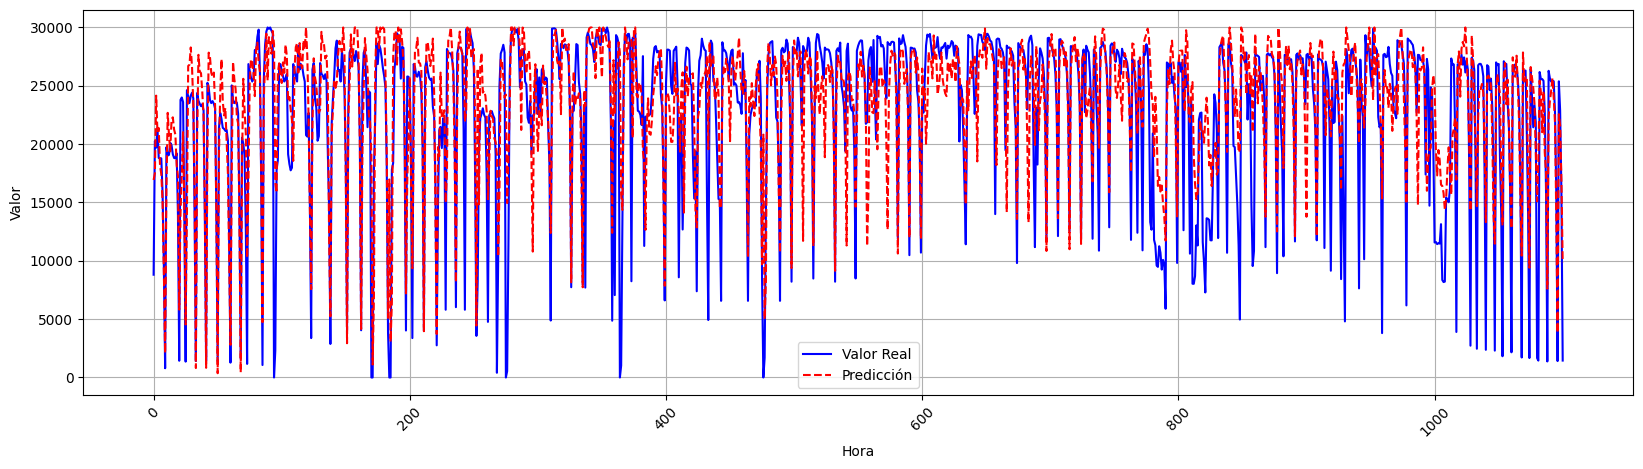

In [128]:
plot_predictions1(model_Soleado, X_Soleado_test, y_Soleado_test, scaler_y, history)